In [1]:
%matplotlib inline
import sys 
import os
import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
import random
import pickle
from pathlib import Path
from itertools import product

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

modpath = "../scripts"
sys.path.append(os.path.abspath(modpath))

from misc import pickler, open_table
import plot_utils

npg = plot_utils.npg_palette(); jco = plot_utils.jco_palette(); colors=plot_utils.matplotlib_init()

/storage/homefs/pd21v747/.local/lib/python3.9/site-packages/pandas/core/computation/expressions.py:21: UserWarning: Pandas requires version '2.8.0' or newer of 'numexpr' (version '2.7.3' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
/storage/homefs/pd21v747/.local/lib/python3.9/site-packages/pandas/core/arrays/masked.py:62: UserWarning: Pandas requires version '1.3.4' or newer of 'bottleneck' (version '1.3.2' currently installed).
  from pandas.core import (


In [2]:
DEAs = ["edgerlrt", "edger", "deseq2"]
outlier_methods = ["none","jk","pcah"]
all_N = [3,4,5,6,7,8,9,10,12,15]

# pretty names
prdea = {"edgerlrt":"edgeR LRT","edger":"edgeR QLF","edgerqlf":"edgeR QLF",
         "deseq2":"DESeq2 Wald","DESeq2":"DESeq2 Wald","wilcox":"Wilcoxon rank-sum"}
prout = {"none":"None","jk":"Jackknife","pcah":"rPCA"}

sites = {"thyroid": "THCA",
         "lung": "LUAD",
         "kidney": "KIRC",
         "colorectal": "COAD",
         "breast": "BRCA",
         "liver": "LIHC",
         "prostate": "PRAD"}

sns.set_style("whitegrid", {'axes.linewidth': 2, 'axes.edgecolor':'black'})

In [3]:
from misc import Timer
with Timer(name="context manager"):
    pass

Elapsed time: 0.0000 seconds


# Effect size inflation vs FDR 

Reviewer 1 comment: 

"It seems counterintuitive that, in small cohorts, the effect estimates are inflated (Fig. 5), but this doesn’t inflate the false positive rate (Fig. 2). Can you explain this? Is it that the effects are high variance but still unbiased? Perhaps you can find a way to simultaneously visualize effect sizes and whether they eventually lead to false positives."

In [8]:
from misc import open_table, get_grid_size
from process import gene_rep

datapath = "../data"

def gene_reps_all_N(all_N,site,data,out,dea,FDR,logFC,param_set):
    gene_reps = {N: None for N in all_N}
    for N in all_N:
        tab = open_table(f"{datapath}/{site}/{data}/{data}_N{N}/all.FDR.{out}.{dea}.{param_set}")
        tablfc = open_table(f"{datapath}/{site}/{data}/{data}_N{N}/all.logFC.{out}.{dea}.{param_set}")
        gene_reps[N] = gene_rep(tab, logFC_tab=tablfc, FDR=FDR, logFC=logFC, normalize=True)
    return gene_reps


def get_truth_logFC(param_set, n_cohorts):
    
    logFC_test = 0 if param_set == "p1" else 1
    
    truth_logFC = {data: {dea: {N: {"RMSE":[], "logFC":[], "Error": []} for N in all_N_sub} | {"small_N_deg_logFC":[],"small_N_deg_logFC_truth":[]} for dea in DEAs} for data in datasets if "syn_hom" not in data}

    for data in truth_logFC:
        
        print(data)
        
        for dea in ["deseq2", "edgerlrt"]:
            
            path = datasets[data]['datapath'].split(f'/{data}.csv')[0]
            f = f"{path}/{data}.{dea}.lfc{logFC_test}.csv"
            truth_df=pd.read_csv(f, index_col=0, usecols=["Unnamed: 0","logFC"])
            logFC_truth = truth_df["logFC"]
            truth_logFC[data][dea]["truth"] = logFC_truth
            small_N_deg = []
            
            for N in all_N_sub:
                
                path_N = f"{path}/{data}_N{N}"
                cohorts = sorted([f.path for f in os.scandir(path_N) if f.is_dir()])

                for cohort in cohorts[:n_cohorts]:
                    
                    f = f"{cohort}/tab.{out}.{dea}.{param_set}"
                    tab_cohort = open_table(f)

                    logFC_cohort = tab_cohort["logFC"]
                    
                    if cohort == cohorts[0]: 
                        common = logFC_cohort.index.intersection(logFC_truth.index)
                    tab_cohort = tab_cohort.loc[common]

                    if N == all_N_sub[0]:
                        DEG = tab_cohort[(tab_cohort["FDR"]<FDR) & (tab_cohort["logFC"].abs()>logFC)]
                        truth_logFC[data][dea]["small_N_deg_logFC"] += DEG["logFC"].values.tolist()
                        small_N_deg = DEG.index

                    logFC_cohort = tab_cohort["logFC"]
                    rmse = np.sqrt(np.mean((logFC_truth.loc[common].values.flatten()-logFC_cohort.values)**2))
                    truth_logFC[data][dea][N]["RMSE"].append(rmse)
                    truth_logFC[data][dea][N]["Error"] += (logFC_truth.loc[common].values.flatten()-logFC_cohort.values).tolist()
                    truth_logFC[data][dea][N]["logFC"] += logFC_cohort.tolist()

            truth_logFC[data][dea]["small_N_deg_logFC_truth"] += logFC_truth.loc[small_N_deg].values.tolist()
            
    return truth_logFC

# don't forget: deseq2 does not show logCPM but counts

In [9]:
datasetsfile = "../data/multi/datasets_wilcox.txt"
with open(datasetsfile, "rb") as f:
    datasets = pickle.load(f)

In [8]:
data = "BRCA"
dea = "deseq2"
out = "none"
N = 3

# not FC estimate is not affected by this
paramset = "p1" # no FC cutoff
paramset = "p2" # formal

site = datasets[data]["site"]
p = f"../data/{site}/{data}/{data}_N{N}/all.logFC.{out}.{dea}.{paramset}"
tab = open_table(p)

p = f"../data/{site}/{data}/{data}_N{N}/all.FDR.{out}.{dea}.{paramset}"
tab_fdr = open_table(p)

mean_lfc = tab.median(axis=1).sort_values(ascending=False)
x = range(len(mean_lfc))

print(len(tab))
tab.head()

18758


,1,2,3,4,5,6,7,8,9,10,...,91,92,93,94,95,96,97,98,99,100
Row,,,,,,,,,,,,,,,,,,,,,
ENSG00000000003,-1.236981,-1.065117,-0.318140,-1.186168,-0.676663,-1.488532,-0.687032,-0.358138,-0.958077,-0.320728,...,-1.451673,-1.564017,-1.386630,-0.167985,-0.524379,-0.581197,0.015136,-0.157270,-0.341198,-2.133774
ENSG00000000005,-3.528613,-4.902033,-3.827559,-3.964970,-4.767310,-2.915722,-1.872100,-2.369576,-3.767920,-4.767497,...,-2.691366,-5.365635,-4.805764,-5.610838,-6.116199,-2.200954,-2.804036,-4.849663,-2.986883,-5.661870
ENSG00000000419,0.577069,0.723840,0.588718,0.255762,0.330952,0.244730,0.200505,0.526518,0.980073,0.204495,...,0.975265,0.499734,0.517676,0.012265,0.669335,0.644969,0.236851,0.016368,0.885193,0.458471
ENSG00000000457,0.220223,0.120000,0.840541,0.327299,0.249410,0.382624,0.298660,0.717217,0.326496,0.769161,...,0.715313,0.103679,0.300795,0.849556,0.994531,0.290377,1.160360,1.593258,0.970101,1.198252
ENSG00000000460,0.600733,1.134824,1.695607,0.892396,1.021273,1.016350,0.758681,1.711125,1.321755,0.931396,...,1.298043,0.943413,0.756048,1.414260,1.703092,1.047787,1.700460,1.421378,2.196038,1.999289


In [9]:
# not really a confidence interval
CI = 0.5
up_lim = (1+CI)/2
low_lim = (1-CI)/2
cutoff = 1

#std_lfc = tab.std(axis=1).loc[mean_lfc.index]
up = tab.quantile(up_lim,axis=1).loc[mean_lfc.index]
low = tab.quantile(low_lim,axis=1).loc[mean_lfc.index]

crossing = mean_lfc[ ((up>-cutoff) & (low<-cutoff)) | ((up>cutoff) & (low<cutoff)) ]
cross_ind = np.array(x)[mean_lfc.index.isin(crossing.index)]

mean_pass_cutoff = mean_lfc[mean_lfc.abs()>cutoff]

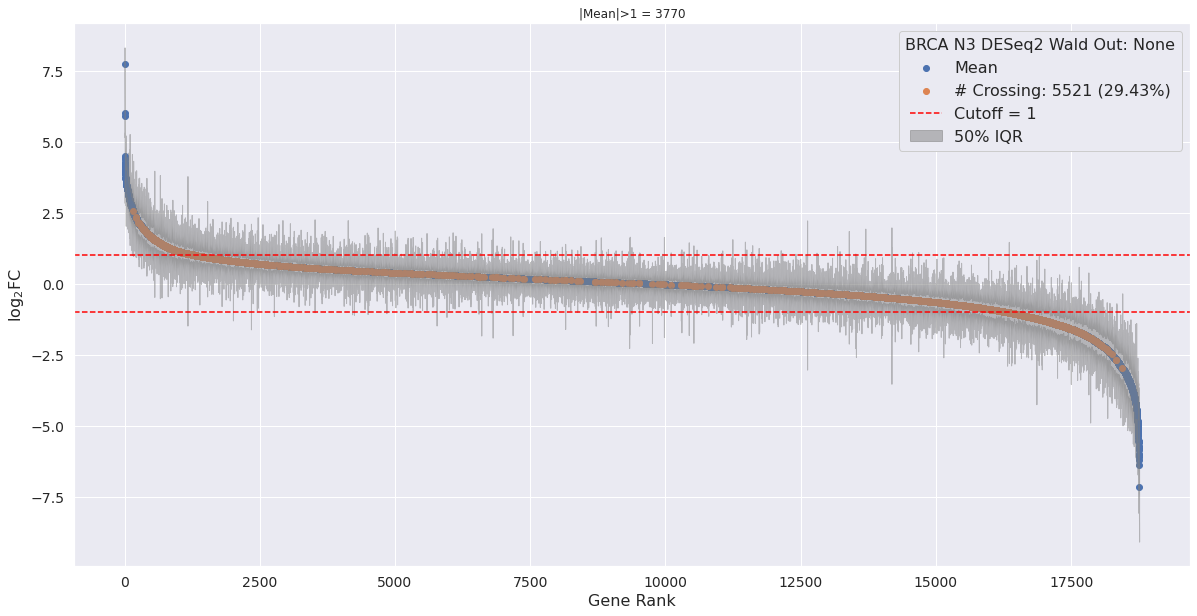

In [10]:
fig, ax = plt.subplots(1,1,figsize=(20,10))
#ax.plot(x, mean_lfc,lw=4,label="Mean")
ax.scatter(x, mean_lfc,label="Mean")
ax.scatter(cross_ind, crossing, label=f"# Crossing: {len(crossing)} ({len(crossing)/len(x):.2%})")
ax.axhline(cutoff,ls="--",c="red",label=f"Cutoff = {cutoff}")
ax.axhline(-cutoff,ls="--",c="red")
ax.fill_between(x, up, low, edgecolor="none",color="grey",alpha=0.5,label=f"{CI:.0%} IQR")
#ax.fill_between(cross_ind, up.iloc[cross_ind], low.iloc[cross_ind], edgecolor="none",color="pink",alpha=0.5,label="Crossing")
ax.set_xlabel("Gene Rank")
ax.set_ylabel(r"log$_2$FC")
ax.set_title(f"|Mean|>{cutoff} = {len(mean_pass_cutoff)}")
ax.legend(framealpha=1,title=f"{data} N{N} {prdea[dea]} Out: {prout[out]}",title_fontsize=16)
#ax.set_xlim(8360,8400)

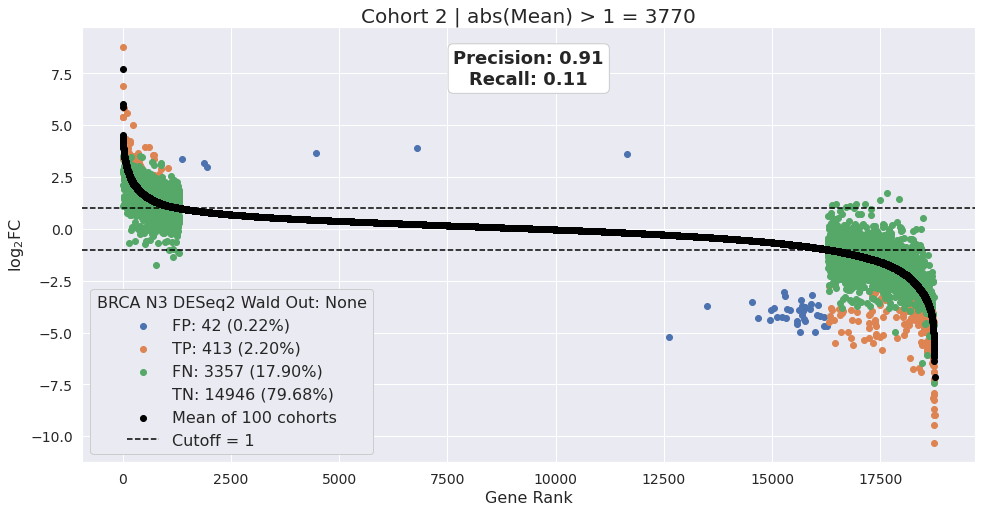

In [11]:
fig, ax = plt.subplots(1,1,figsize=(16,8))

fdr_thresh = 0.05
cohort = 2

## Post hoc thresholding
tab_cohort =  tab.iloc[:,cohort-1].loc[mean_lfc.index]
tab_cohort_fdr =  tab_fdr.iloc[:,cohort-1].loc[mean_lfc.index]

if (tab_cohort_fdr.isna().sum()):
    tab_cohort_fdr = tab_cohort_fdr.fillna(1)
    
mask = (tab_cohort.abs() >= 1) & (mean_lfc.abs()<1) & (tab_cohort_fdr<fdr_thresh)
tab_cohort_FP = tab_cohort[mask]
x_FP = np.array(x)[mask]

mask = (tab_cohort.abs() >= 1) & (mean_lfc.abs()>=1) & (tab_cohort_fdr<fdr_thresh)
tab_cohort_TP = tab_cohort[mask]
x_TP = np.array(x)[mask]

mask = (mean_lfc.abs()>=1) & (tab_cohort_fdr>=fdr_thresh)
tab_cohort_FN = tab_cohort[mask]
x_FN = np.array(x)[mask]

mask = (mean_lfc.abs()<1) & (tab_cohort_fdr>=fdr_thresh)
tab_cohort_TN = tab_cohort[mask]
x_TN = np.array(x)[mask]

assert len(x_TP) + len(x_FP) + len(x_FN) + len(x_TN) == len(x)

#ax.plot(x, mean_lfc,lw=4,label="Mean")
ax.scatter(x_FP, tab_cohort_FP,label=f"FP: {len(x_FP)} ({len(x_FP)/len(x):.2%})", zorder=2)
ax.scatter(x_TP, tab_cohort_TP,label=f"TP: {len(x_TP)} ({len(x_TP)/len(x):.2%})", zorder=2)
ax.scatter(x_FN, tab_cohort_FN,label=f"FN: {len(x_FN)} ({len(x_FN)/len(x):.2%})", zorder=2)
ax.scatter(x_TN, tab_cohort_TN,label=f"TN: {len(x_TN)} ({len(x_TN)/len(x):.2%})", zorder=2, alpha=0)
ax.scatter(x, mean_lfc,label="Mean of 100 cohorts", zorder=3, color="black")

#ax.scatter(cross_ind, crossing, label=f"# Crossing: {len(crossing)} ({len(crossing)/len(x):.2%})")
ax.axhline(cutoff,ls="--",c="black",label=f"Cutoff = {cutoff}", zorder=9)
ax.axhline(-cutoff,ls="--",c="black", zorder=9)

bbox=dict(boxstyle="round", fc="1",ec="0.8")
prec = len(x_TP) / (len(x_TP) + len(x_FP))
rec = len(x_TP) / (len(x_TP) + len(x_FN))
metrics = f"Precision: {prec:.2f}\nRecall: {rec:.2f}"
ax.text(0.5, 0.95, metrics, ha='center', va='top', transform=ax.transAxes, bbox=bbox, fontsize=18, weight="bold")

ax.set_xlabel("Gene Rank")
ax.set_ylabel(r"log$_2$FC")
ax.set_title(f"Cohort {cohort} | abs(Mean) > {cutoff} = {len(mean_pass_cutoff)}", fontsize=20)
ax.legend(framealpha=1,title=f"{data} N{N} {prdea[dea]} Out: {prout[out]}",title_fontsize=16)
#ax.set_xlim(8360,8400)

<Axes: >

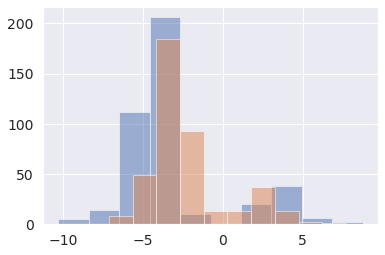

In [12]:
tab_cohort_TP.hist(bins=10,alpha=0.5)
mean_lfc.loc[tab_cohort_TP.index].hist(bins=10,alpha=0.5)

In [14]:
site = datasets[data]["site"]
p = f"../data/{site}/{data}/{data}.{dea}.lfc{0}"
tab_gt = open_table(p)
print(len(tab_gt))
tab_gt.head()

18758


,logCPM,logFC,lfcSE,stat,PValue,FDR
ENSG00000000003,3673.607943,-0.929570,0.102329,-9.084154,1.045084e-19,4.269094e-19
ENSG00000000005,454.277134,-5.002808,0.219331,-22.809398,3.699099e-115,3.965012e-113
ENSG00000000419,2050.051886,0.404827,0.055012,7.358840,1.855159e-13,5.433111e-13
ENSG00000000457,1797.627987,0.509953,0.063218,8.066606,7.227908e-16,2.412905e-15
ENSG00000000460,593.953982,1.300195,0.075208,17.288072,5.785530e-67,1.411248e-65


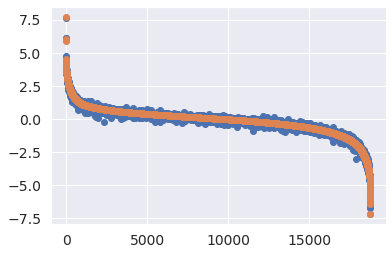

In [15]:
a=tab_gt.loc[mean_lfc.index.intersection(tab_gt.index)]["logFC"]
# (a-mean_lfc).hist(bins=100)
# (a-mean_lfc).mean()

plt.scatter(range(len(a)), a,label="Mean of 100 cohorts", zorder=3)
plt.scatter(x, mean_lfc,label="Mean of 100 cohorts", zorder=4)

## Heteroskedasticity

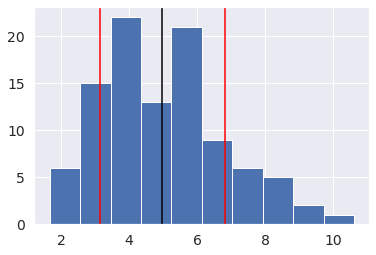

In [16]:
i = 1
m = tab.abs().iloc[i].mean()
s = tab.abs().iloc[i].std()
tab.abs().iloc[i].hist()
plt.axvline(m, color="black")
plt.axvline(m-s, color="red")
plt.axvline(m+s, color="red")

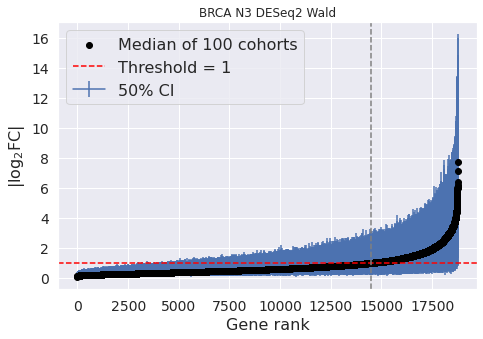

In [17]:
CI = 0.5
up_lim = (1+CI)/2
low_lim = (1-CI)/2

cutoff = 1

mean_lfc = tab.abs().median(axis=1).sort_values(ascending=True)

up = tab.abs().quantile(up_lim,axis=1).loc[mean_lfc.index]
low = tab.abs().quantile(low_lim,axis=1).loc[mean_lfc.index]
spread = np.array([low.values, up.values])

# spread = tab.abs().std(axis=1).loc[mean_lfc.index]

cutoff = 1

fig, ax= plt.subplots(1,1,figsize=(7,5))
ax.errorbar(range(len(mean_lfc)), mean_lfc, yerr=spread,zorder=1, label=f"{CI:.0%} CI")
ax.scatter(range(len(mean_lfc)), mean_lfc,color="black",zorder=2, label="Median of 100 cohorts")
ax.set(ylabel=r"|log$_2$FC|",xlabel="Gene rank", title=f"{data} N{N} {prdea[dea]}")
ax.axhline(cutoff,ls="--",color="red",label=f"Threshold = {cutoff}")
ax.axvline(np.argmax(mean_lfc>1),ls="--",color="grey",label=f"")

ax.legend(loc="upper left")

fig.tight_layout()
figpath = f"../figures/heteroskedasticity.png"
fig.savefig(figpath)

## New

In [69]:
site = "breast"
N = 3
paramset = "p1"
dea = "edgerlrt"


fdr = 0.05
lfc_post = 1

In [70]:
f_truth = f"../data/{site}/{sites[site]}/truth_lfc.csv"
truth = open_table(f_truth)

f_truth = f"../data/{site}/{sites[site]}/truth.fdr{fdr}.post_lfc{lfc_post}.lfc0.csv"
truth_deg = open_table(f_truth)
len(truth_deg)

3580

In [71]:
f = f"../data/{site}/{sites[site]}/{sites[site]}_N{N}/all.logFC.none.{dea}.{paramset}.feather"
tab = open_table(f)

f = f"../data/{site}/{sites[site]}/{sites[site]}_N{N}/all.FDR.none.{dea}.{paramset}.feather"
tab_FDR = open_table(f)

In [72]:
order = truth.sort_index().index
truth = truth.loc[order]
tab = tab.loc[order]
tab_FDR = tab_FDR.loc[order]

len(tab), len(tab_FDR)

(18758, 18758)

In [73]:
from sklearn.linear_model import LinearRegression
    
scores, coefs = [], []
scores_deg, coefs_deg = [], []
scores_deg_lfc, coefs_deg_lfc = [], []
sigs, sigs_lfc = [], []

for i, cohort in enumerate(tab):
    
    ## all genes
    X = truth["logFC"].values.reshape(-1, 1)
    y = tab[cohort].values.reshape(-1, 1)
    reg = LinearRegression().fit(X, y)
    scores.append(reg.score(X, y))
    coefs.append(reg.coef_[0][0])
    
    ## DEG only with pval
    sig = tab_FDR[cohort] < fdr
    sigs.append(sig.sum())
    X = truth[sig]["logFC"].values.reshape(-1, 1)
    y = tab[sig][cohort].values.reshape(-1, 1)
    reg = LinearRegression().fit(X, y)
    scores_deg.append(reg.score(X, y))
    coefs_deg.append(reg.coef_[0][0])
    
    ## DEG only with lfc thresh
    sig = (tab_FDR[cohort] < fdr) & (tab[cohort].abs() > lfc_post)
    sigs_lfc.append(sig.sum())
    X = truth[sig]["logFC"].values.reshape(-1, 1)
    y = tab[sig][cohort].values.reshape(-1, 1)
    reg = LinearRegression().fit(X, y)
    scores_deg_lfc.append(reg.score(X, y))
    coefs_deg_lfc.append(reg.coef_[0][0])

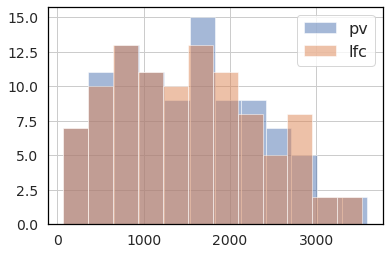

In [74]:
plt.hist(sigs, alpha=0.5, bins=12, label="pv")
plt.hist(sigs_lfc, alpha=0.5, bins=12, label="lfc")
plt.legend()

(1.2520640432701766, 1.005845457686018)

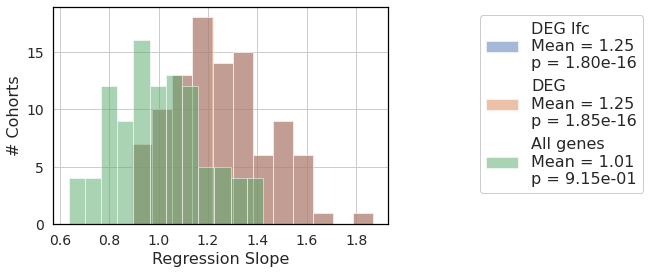

In [75]:
from scipy.stats import wilcoxon

stat, pval = wilcoxon(np.array(coefs) - 1)
stat_deg, pval_deg = wilcoxon(np.array(coefs_deg) - 1)
stat_deg_lfc, pval_deg_lfc = wilcoxon(np.array(coefs_deg_lfc) - 1)

plt.hist(coefs_deg_lfc, alpha=0.5, bins=12, label=f"DEG lfc\nMean = {np.mean(coefs_deg_lfc):.2f}\np = {pval_deg_lfc:.2e}")
plt.hist(coefs_deg, alpha=0.5, bins=12, label=f"DEG\nMean = {np.mean(coefs_deg):.2f}\np = {pval_deg:.2e}")
plt.hist(coefs, alpha=0.5, bins=12,  label=f"All genes\nMean = {np.mean(coefs):.2f}\np = {pval:.2e}")

plt.legend(bbox_to_anchor=(1.25, 1), framealpha=1)
plt.xlabel("Regression Slope")
plt.ylabel("# Cohorts")
np.mean(coefs_deg), np.mean(coefs)

In [36]:
cohort = "86"

X = truth["logFC"]
y = tab[cohort]
score, coef = scores[int(cohort)-1], coefs[int(cohort)-1]
score, coef

sig = (tab_FDR[cohort] < fdr) & (tab[cohort].abs() > lfc_post)
X_deg = truth[sig]["logFC"]
y_deg = tab[sig][cohort]
score_deg, coef_deg = scores_deg[int(cohort)-1], coefs_deg[int(cohort)-1]

In [37]:
#hue = tab_FDR[cohort]

hue = X.index.isin(truth_deg.index)
hue_deg = X_deg.index.isin(truth_deg.index)

TP = hue_deg.sum()
FP = (~hue_deg).sum()
precision = TP / (TP+FP)
print(precision)

0.7448796263025512


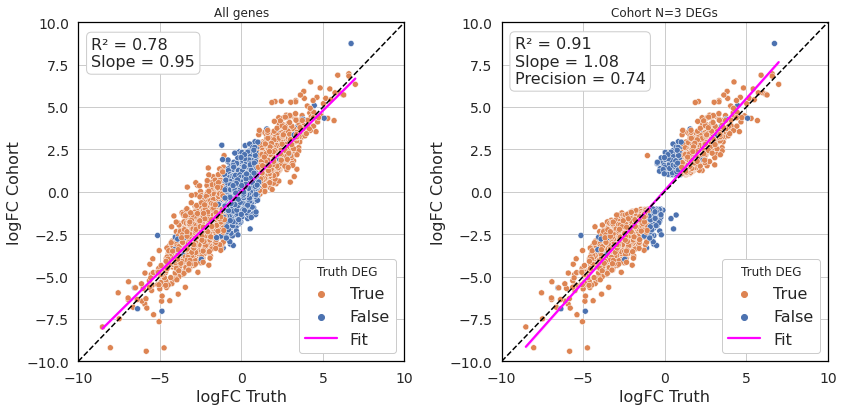

In [38]:
sns.set_style("whitegrid", {'axes.linewidth': 2, 'axes.edgecolor':'black'})
bbox=dict(boxstyle="round", fc="1",ec="0.8")

fig, ax = plt.subplots(1,2, figsize=(12,6))

sns.regplot(x=X, y=y, line_kws=dict(color="magenta",zorder=98,label="Fit"), scatter_kws=dict(alpha=0), ax=ax[0])
sns.scatterplot(x=X, y=y, hue=hue, ax=ax[0])

sns.regplot(x=X_deg, y=y_deg, line_kws=dict(color="magenta",zorder=98,label="Fit"), scatter_kws=dict(alpha=0), ax=ax[1])
sns.scatterplot(x=X_deg, y=y_deg, hue=hue_deg, ax=ax[1])

ax[0].annotate(f"R² = {score:.2f}\nSlope = {coef:.2f}", xy=(0.04,0.87), xycoords="axes fraction",bbox=bbox)
ax[1].annotate(f"R² = {score_deg:.2f}\nSlope = {coef_deg:.2f}\nPrecision = {precision:.2f}", xy=(0.04,0.82), xycoords="axes fraction",bbox=bbox)

ax[0].set(title="All genes")
ax[1].set(title=f"Cohort N={N} DEGs")

for a in ax: 
    a.set(xlim=(-10,10),ylim=(-10,10), ylabel="logFC Cohort", xlabel="logFC Truth")
    a.plot((-10,10),(-10,10),ls="--",c="black",zorder=99)
    #a.get_legend().remove()
    handles, labels = a.get_legend_handles_labels()
    a.legend(handles[::-1], labels[::-1], loc="lower right",framealpha=1,title="Truth DEG")
        
fig.tight_layout()

<Axes: xlabel='logFC'>

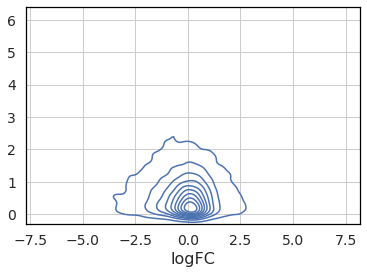

In [29]:
sns.kdeplot(x=X, y=np.abs(X-y))

# logFC vs Precision

In [12]:
data = "THCA"
dea = "edgerlrt"
out = "none"
N = 3

# not FC estimate is not affected by this
paramset = "p1" # no FC cutoff
paramset = "p2" # formal

site = datasets[data]["site"]
p = f"../data/{site}/{data}/{data}_N{N}/all.logFC.{out}.{dea}.{paramset}"
tab_lfc = open_table(p)

p = f"../data/{site}/{data}/{data}_N{N}/all.FDR.{out}.{dea}.{paramset}"
tab_fdr = open_table(p)

In [13]:
site = datasets[data]["site"]
p = f"../data/{site}/{data}/{data}.{dea}.lfc{1 if paramset == 'p2' else 0}"
tab_gt = open_table(p)

tab_lfc = tab_lfc.loc[tab_gt.index]
tab_fdr = tab_fdr.loc[tab_gt.index]

print(len(tab_gt))
tab_gt.head()

18953


,logFC,unshrunk.logFC,logCPM,PValue,FDR
ENSG00000145864,7.025407,7.034397,5.664089,4.631859e-53,8.778762e-49
ENSG00000163898,6.406799,6.413529,5.154644,5.224155e-51,4.950671e-47
ENSG00000174460,6.857950,6.859785,8.439239,8.151438e-48,5.149807e-44
ENSG00000162873,5.284868,5.289279,4.841493,1.260347e-46,5.971837e-43
ENSG00000176532,5.935539,5.939020,5.804754,5.203101e-45,1.972287e-41


In [14]:
fdr = 0.05
deg_truth = tab_gt[tab_gt["FDR"]<fdr]
len(deg_truth)

1570

In [15]:
deg_cohorts = tab_fdr.mask(tab_fdr<fdr,1).mask(tab_fdr>=fdr,0)

In [16]:
tab_gt["sig"] = 0
tab_gt["sig"] = tab_gt["sig"].where(tab_gt["FDR"]>=fdr,1)
tab_gt["sig"].sum()

1570

In [20]:
from process import get_array_metrics_numba

mcc, prec, rec, mcc0, prec0 = get_array_metrics_numba(tab_gt["sig"].values, deg_cohorts.values)

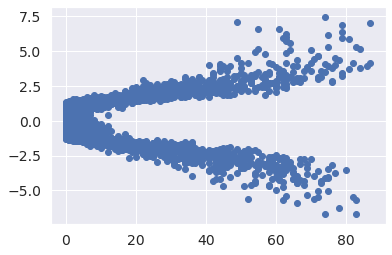

In [21]:
plt.scatter(deg_cohorts.sum(axis=1), tab_gt["logFC"])

In [22]:
mcc, prec, rec, mcc0, prec0 = get_array_metrics_numba(tab_gt["sig"].values, deg_cohorts.values)

In [24]:
tab_gt = tab_gt.sort_values(by="logFC")
deg_cohorts = deg_cohorts.loc[tab_gt.index]
bins = np.linspace(tab_gt["logFC"].min()-0.1, tab_gt["logFC"].max()+0.1, 20)
tab_gt['logFC_bin'] = pd.cut(tab_gt['logFC'], bins)

prec_dict = {}
for bin_val, bin_group in tab_gt.groupby('logFC_bin'):
    mcc, prec, rec, mcc0, prec0 = get_array_metrics_numba(bin_group["sig"].values, deg_cohorts.loc[bin_group.index].values)
    prec_dict[bin_val] = prec

(-6.83, -6.072]
Median prec: 1.0
Genes: 3 | NaN: 9


(-6.072, -5.314]
Median prec: 1.0
Genes: 9 | NaN: 7


(-5.314, -4.556]
Median prec: 1.0
Genes: 10 | NaN: 11


(-4.556, -3.797]
Median prec: 1.0
Genes: 30 | NaN: 3


(-3.797, -3.039]
Median prec: 1.0
Genes: 74 | NaN: 3


(-3.039, -2.281]
Median prec: 1.0
Genes: 146 | NaN: 4


(-2.281, -1.523]
Median prec: 0.9803921568627451
Genes: 386 | NaN: 3


(-1.523, -0.765]
Median prec: 0.31089536138079826
Genes: 1316 | NaN: 4


(-0.765, -0.00638]
Median prec: 0.0
Genes: 7259 | NaN: 12


(-0.00638, 0.752]
Median prec: 0.0
Genes: 7783 | NaN: 20


(0.752, 1.51]
Median prec: 0.3157894736842105
Genes: 1331 | NaN: 6


(1.51, 2.268]
Median prec: 0.98
Genes: 348 | NaN: 3


(2.268, 3.026]
Median prec: 1.0
Genes: 152 | NaN: 2


(3.026, 3.785]
Median prec: 1.0
Genes: 51 | NaN: 3


(3.785, 4.543]
Median prec: 1.0
Genes: 28 | NaN: 4


(4.543, 5.301]
Median prec: 1.0
Genes: 11 | NaN: 6


(5.301, 6.059]
Median prec: 1.0
Genes: 7 | NaN: 11


(6.059, 6.817]
Medi

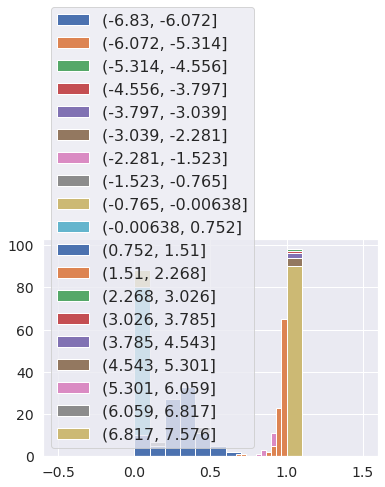

In [26]:
mid = []
precs = []
for bin_val, bin_group in tab_gt.groupby('logFC_bin'):
    mcc, prec, rec, mcc0, prec0 = get_array_metrics_numba(bin_group["sig"].values, deg_cohorts.loc[bin_group.index].values)
    mid.append(bin_val.mid)
    precs.append(np.nanmedian(prec))
    
    print(bin_val)
    print("Median prec:", np.nanmedian(prec))
    print("Genes:",len(bin_group),"| NaN:", np.isnan(prec).sum())
    plt.hist(prec, label=bin_val)
    print("\n")
    
plt.legend()

Text(0, 0.5, 'Median precision')

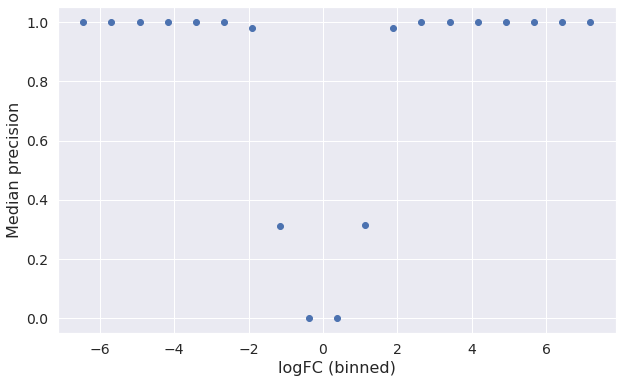

In [28]:
plt.figure(figsize=(10,6))
plt.scatter(mid,precs)
plt.xlabel("logFC (binned)")
plt.ylabel("Median precision")

## Inflation

In [ ]:
from misc import open_table, get_grid_size
from process import gene_rep

datapath = "/storage/homefs/pd21v747/datanew"

def gene_reps_all_N(all_N,site,data,out,dea,FDR,logFC,param_set):
    gene_reps = {N: None for N in all_N}
    for N in all_N:
        tab = open_table(f"{datapath}/{site}/{data}/{data}_N{N}/all.FDR.{out}.{dea}.{param_set}")
        tablfc = open_table(f"{datapath}/{site}/{data}/{data}_N{N}/all.logFC.{out}.{dea}.{param_set}")
        gene_reps[N] = gene_rep(tab, logFC_tab=tablfc, FDR=FDR, logFC=logFC, normalize=True)
    return gene_reps


def get_truth_logFC(param_set, n_cohorts):
    
    logFC_test = 0 if param_set == "p1" else 1
    
    truth_logFC = {data: {dea: {N: {"RMSE":[], "logFC":[], "Error": []} for N in all_N_sub} | {"small_N_deg_logFC":[],"small_N_deg_logFC_truth":[]} for dea in DEAs} for data in datasets if "syn_hom" not in data}

    for data in truth_logFC:
        
        print(data)
        
        for dea in ["deseq2", "edgerlrt"]:
            
            path = datasets[data]['datapath'].split(f'/{data}.csv')[0]
            f = f"{path}/{data}.{dea}.lfc{logFC_test}.csv"
            truth_df=pd.read_csv(f, index_col=0, usecols=["Unnamed: 0","logFC"])
            logFC_truth = truth_df["logFC"]
            truth_logFC[data][dea]["truth"] = logFC_truth
            small_N_deg = []
            
            for N in all_N_sub:
                
                path_N = f"{path}/{data}_N{N}"
                cohorts = sorted([f.path for f in os.scandir(path_N) if f.is_dir()])

                for cohort in cohorts[:n_cohorts]:
                    
                    f = f"{cohort}/tab.{out}.{dea}.{param_set}"
                    tab_cohort = open_table(f)

                    logFC_cohort = tab_cohort["logFC"]
                    
                    if cohort == cohorts[0]: 
                        common = logFC_cohort.index.intersection(logFC_truth.index)
                    tab_cohort = tab_cohort.loc[common]

                    if N == all_N_sub[0]:
                        DEG = tab_cohort[(tab_cohort["FDR"]<FDR) & (tab_cohort["logFC"].abs()>logFC)]
                        truth_logFC[data][dea]["small_N_deg_logFC"] += DEG["logFC"].values.tolist() # faster than np.concatenate
                        small_N_deg = DEG.index

                    logFC_cohort = tab_cohort["logFC"]
                    rmse = np.sqrt(np.mean((logFC_truth.loc[common].values.flatten()-logFC_cohort.values)**2))
                    truth_logFC[data][dea][N]["RMSE"].append(rmse)
                    truth_logFC[data][dea][N]["Error"] += (logFC_truth.loc[common].values.flatten()-logFC_cohort.values).tolist()
                    truth_logFC[data][dea][N]["logFC"] += logFC_cohort.tolist()

            truth_logFC[data][dea]["small_N_deg_logFC_truth"] += logFC_truth.loc[small_N_deg].values.tolist()
            
    return truth_logFC

# don't forget: deseq2 does not show logCPM but counts

In [ ]:
all_N_sub = [3,9,15]
FDR = 0.01
logFC = 1
out = "none" # outlier method
n_cohorts = 10
overwrite = False
paramset = "p1"

truth_logFC = get_truth_logFC(paramset, n_cohorts)

In [ ]:
print(truth_logFC["THCA"]["edgerlrt"].keys())

len(truth_logFC["THCA"]["edgerlrt"]["small_N_deg_logFC"])
len(truth_logFC["THCA"]["edgerlrt"]["small_N_deg_logFC_truth"])

# Unpaired designs

In [15]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

combined_td2 = pd.read_csv("../data/multi/combined_td.p2.csv", index_col=0) # Paired formal lfc 1
combined_td3 = pd.read_csv("../data/multi/combined_td.p3.csv", index_col=0) # Unpaired formal lfc 1

combined_td3["DEA"] = combined_td3["DEA"].str.replace("edgerqlf","edgeR QLF")

In [16]:
combined_td2 = combined_td2[(combined_td2["N"].isin([3,7,15]))&(combined_td2["FDR"]==0.05)]

len(combined_td2),len(combined_td3)

(63, 81)

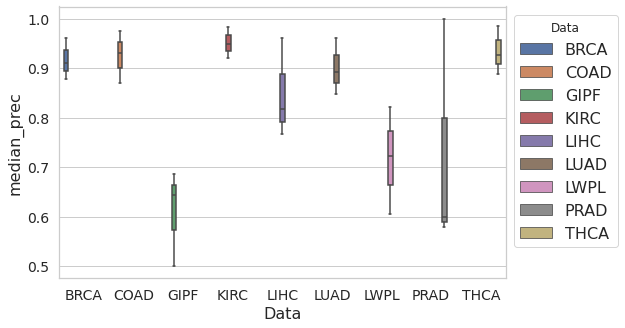

In [18]:
c = combined_td3[combined_td3["N"]==3]

gih, ax = plt.subplots(1,1,figsize=(8,5))
sns.boxplot(data=c,x="Data",y="median_prec",hue="Data",ax=ax)
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))

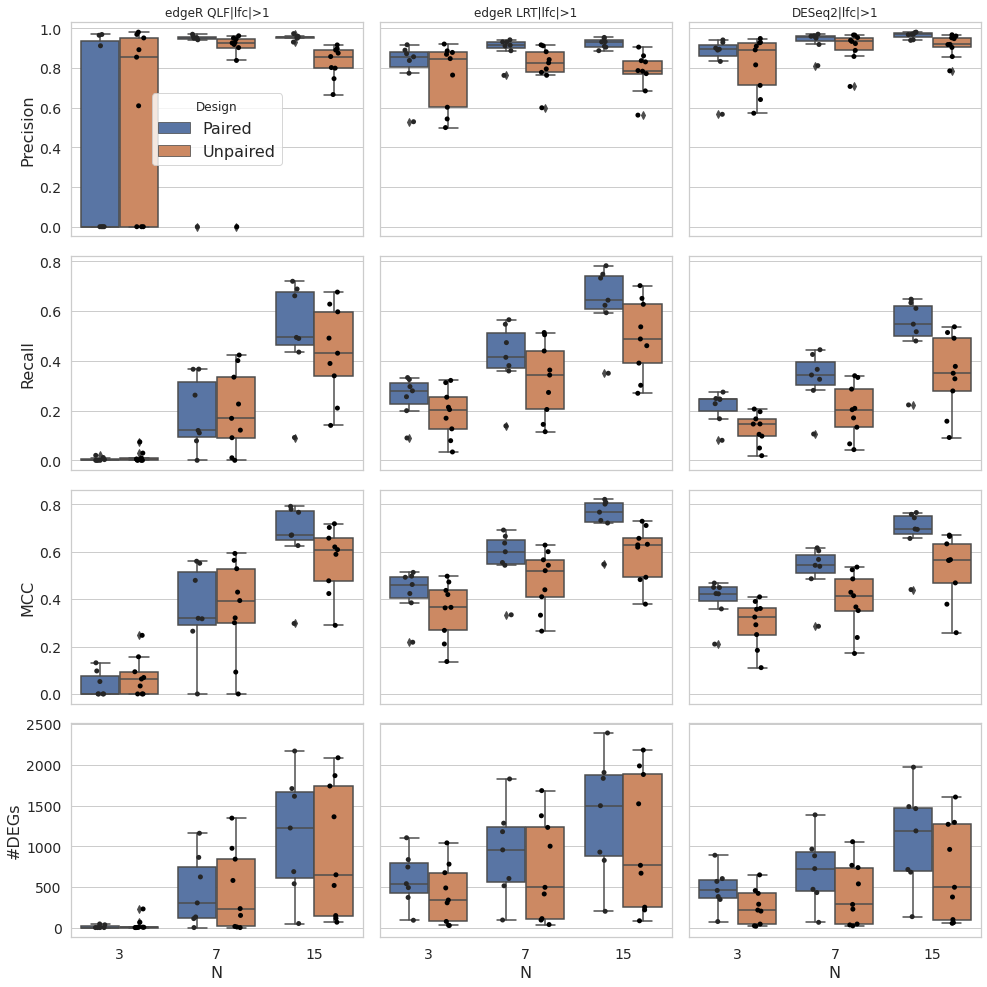

In [23]:
sns.set_style("whitegrid")

combined_td2["Design"] = "Paired"
combined_td3["Design"] = "Unpaired"
combined_td2["DEA"].replace("edgerqlf","edgeR QLF", inplace=True)

df = pd.concat([combined_td2, combined_td3])

met = "median_prec0"

fig, ax = plt.subplots(4,3,figsize=(14,14), sharex=True, sharey="row")

methods = ["edgeR QLF", "edgeR LRT", "DESeq2"]
pretty_metric = {"median_prec0": "Precision",
                "median_deg": "#DEGs",
                "median_rec": "Recall",
                "median_mcc0": "MCC"}

for i, met in enumerate(["median_prec0","median_rec","median_mcc0","median_deg"]):
    for j, method in enumerate(methods):
        df_sub = df[df["DEA"]==method]
        sns.boxplot(data=df_sub, x="N", y=met,hue="Design", ax=ax[i][j])
        if not (i == j == 0): ax[i][j].legend().remove()
        sns.stripplot(data=df_sub, x="N", y=met,hue="Design",dodge=True, color="black", ax=ax[i][j], legend=False)
        ax[i][j].set(ylabel=pretty_metric[met])
        if i < 3: ax[i][j].set(xlabel="")
        if j > 0: ax[i][j].set(ylabel="")
        if i == 0: ax[i][j].set_title(method + "|lfc|>1")
    
fig.tight_layout()
figpath = f"../figures/paired_vs_unpaired_lfc1.png"
fig.savefig(figpath)

## Test cases

In [ ]:
test = "deseq2"
site = "liver"
data = "LIHC"
N = 3
cohort = 1

# Results from sent batch jobs
f3 = f"/storage/homefs/pd21v747/RNASeqReplicability/data/{site}/{data}/{data}_N{N}/{data}_N{N}_{cohort:04}/tab.none.{test}.p3.feather" # unpaired
f2 = f"/storage/homefs/pd21v747/RNASeqReplicability/data/{site}/{data}/{data}_N{N}/{data}_N{N}_{cohort:04}/tab.none.{test}.p2.feather" # paired
tab_unpaired = open_table(f3)
tab_paired = open_table(f2)

# Unpaired and paired results should yield different results
print((tab_paired["logFC"]==tab_unpaired.loc[tab_paired.index]["logFC"]).sum(), len(tab_paired))
(tab_paired["FDR"]==tab_unpaired.loc[tab_paired.index]["FDR"]).sum(), len(tab_paired)

In [ ]:
# Re-run DEA here

from DEA import run_dea
import json

config = f"/storage/homefs/pd21v747/RNASeqReplicability/data/{site}/{data}/{data}_N{N}/{data}_N{N}_{cohort:04}/config.json"

with open(config, "r") as f:
    j = json.load(f)    
    samples_i = j["samples_i"]
    
df_cohort = pd.read_csv(f"/storage/homefs/pd21v747/RNASeqReplicability/data/{site}/{data}/{data}.csv", index_col=0)
df_cohort = df_cohort[samples_i]

outfile = "../data/test/unpaired.csv"
kwargs = {"filter_expr": False, "cols_to_keep": ["logFC","logCPM","FDR"], "lfc": 1, "design": "unpaired"}
if test == "deseq2": kwargs = {"cols_to_keep": ["logFC","logCPM","FDR"],"lfc": 1, "design": "unpaired"}
run_dea(df_cohort, outfile, method=test, overwrite=True, **kwargs)

outfile_paired = "../data/test/paired.csv"
kwargs = {"filter_expr": False, "cols_to_keep": ["logFC","logCPM","FDR"], "lfc": 1, "design": "paired"}
if test == "deseq2": kwargs = {"cols_to_keep": ["logFC","logCPM","FDR"],"lfc": 1, "design": "paired"}
run_dea(df_cohort, outfile_paired, method=test, overwrite=True, **kwargs)

In [ ]:
df_unpaired = pd.read_csv(outfile, index_col=0)
df_paired = pd.read_csv(outfile_paired, index_col=0)
(df_paired["FDR"] == df_unpaired.loc[df_paired.index]["FDR"]).sum(), len(df_paired)

In [ ]:
if test != "deseq2":
    assert np.allclose(df_paired["FDR"], tab_paired.loc[df_paired.index]["FDR"])
    assert np.allclose(df_unpaired["FDR"], tab_unpaired.loc[df_unpaired.index]["FDR"])
else:
    ix = df_paired[~df_paired["FDR"].isna()].index
    assert np.allclose(df_paired.loc[ix, "FDR"], tab_paired.loc[ix]["FDR"])
    ix = df_unpaired[~df_unpaired["FDR"].isna()].index
    assert np.allclose(df_unpaired.loc[ix, "FDR"], tab_unpaired.loc[ix]["FDR"])

In [ ]:
fdr = 0.05
print(len(df_paired[df_paired["FDR"]<fdr]))
print(len(tab_paired[tab_paired["FDR"]<fdr]))
print(len(df_unpaired[df_unpaired["FDR"]<fdr]))
print(len(tab_unpaired[tab_unpaired["FDR"]<fdr]))

# Stratified sampling

In [ ]:
sites = {"liver": "LIHC",
         "thyroid": "THCA",
         "lung": "LUAD",
         "kidney": "KIRC",
         "colorectal": "COAD",
         "breast": "BRCA",
         "prostate": "PRAD",
         "GSETB":"LWPL",
         "GSEBP":"BPLT"} 

site = "liver"

tab = pd.read_csv(f"../data/{site}/{sites[site]}/{sites[site]}.csv", index_col=0)
meta = pd.read_csv(f"../data/{site}/{site}_meta.csv", index_col=0)
meta = meta[tab.columns]
meta

In [60]:
trials = 2
n = 3
confounder = "gender"

In [61]:
from  sklearn.model_selection import train_test_split

X = tab.T
y = meta.loc[confounder]
N = n / (len(X.columns) // 2)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=n, random_state=42, shuffle=True, stratify=y)

In [62]:
yv = y.value_counts()
print(yv[0]/yv[1])
yv

1.2727272727272727


gender
male      56
female    44
Name: count, dtype: int64

In [75]:
ys = []
for t in range(100):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=n, random_state=None, shuffle=True, stratify=y)
    ys += list(y_test.values)

In [76]:
y_test

N39      male
N4     female
N22      male
Name: gender, dtype: object

In [77]:
pv = pd.DataFrame(ys).value_counts()
print(pv[0]/pv[1])
pv

2.0


male      200
female    100
Name: count, dtype: int64

# Wilcoxon

## Truth

In [28]:
import pickle
with open("../data/multi/datasets_wilcox.txt", "rb") as f:
    datasets = pickle.load(f)
    
cancers = ["PRAD","LIHC","LUAD","KIRC","THCA","COAD","BRCA"]
for key in list(datasets.keys()):
    if key not in cancers:
        del datasets[key]

In [29]:
FDRs, logFCs = [0.05], [0,1, "post hoc"]
DEAs = ["edgerqlf", "edgerlrt", "deseq2", "wilcox"]

# Ground truth
iterables = [datasets,[prdea[d] for d in DEAs],FDRs,logFCs]
multi_cols = pd.MultiIndex.from_product(iterables, names=["Data","DEA","FDR","logFC"])
gt = pd.DataFrame(columns=multi_cols)

# Jaccard
iterables = [datasets,FDRs,logFCs]
multi_cols = pd.MultiIndex.from_product(iterables, names=["Data","FDR","logFC"])
gtj = pd.DataFrame(columns=multi_cols)


for data in cancers:
    for i, dea in enumerate(DEAs):
        for fdr in FDRs:
            for lfc in logFCs:
                col = (data,prdea[dea],fdr,lfc)
                if lfc == "post hoc":
                    gt.loc[0,col] = datasets[data]["truth_stats"][0][fdr][1][dea]
                elif not (lfc!=0 and dea == "wilcox"):
                    gt.loc[0,col] = datasets[data]["truth_stats"][lfc][fdr][lfc][dea]
                    
                if i == 0:
                    col = (data,fdr,lfc)
                    if lfc == "post hoc":
                        gtj.loc[0,col] = datasets[data]["truth_stats"][0][fdr][1]["jaccard"]
                    else:
                        gtj.loc[0,col] = datasets[data]["truth_stats"][lfc][fdr][lfc]["jaccard"]
                        
gt=gt.unstack().reset_index(level=["Data","DEA","FDR","logFC"], drop=False)
gt.sort_values(by="DEA", inplace=True)
gt.rename(columns={0: "#DEG"}, inplace=True)
                    
gtj=gtj.unstack().reset_index(level=["Data","FDR","logFC"], drop=False)
gtj.rename(columns={0: "Jaccard"}, inplace=True)

gt=gt[gt["Data"]!="KIRC_syn_hom"]
gt["#DEG"] = gt["#DEG"].astype(float)
gtj["Jaccard"] = gtj["Jaccard"].astype(float)
gtj=gtj[gtj["Data"]!="KIRC_syn_hom"]
df = gt
gtj.index = range(len(gtj))
df.index = range(len(df))
df["DEA"].replace({"Wilcoxon rank-sum":"Wilcoxon"},inplace=True)

In [32]:
order = np.array(["PRAD","LIHC","THCA","COAD","LUAD","BRCA","KIRC"])#,"GIPF","LWPL"])
dea_order = ["DESeq2 Wald", "edgeR LRT", "edgeR QLF", "Wilcoxon"]

gt['Data'] = pd.Categorical(gt['Data'], categories=order, ordered=True)
gtj['Data'] = pd.Categorical(gtj['Data'], categories=order, ordered=True)
gt['DEA'] = pd.Categorical(gt['DEA'], categories=dea_order, ordered=True)
gt = gt.sort_values(by=['Data', 'DEA'])
gtj = gtj.sort_values(by=['Data'])

../figures/sfig21_ground_truth_size_with_wilcox.pdf


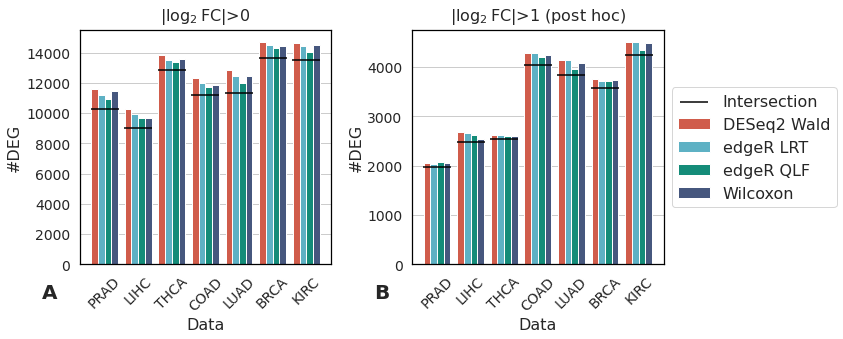

In [36]:
npg = plot_utils.npg_palette(); jco = plot_utils.jco_palette(); colors=plot_utils.matplotlib_init()
sns.set_style("whitegrid", {'axes.linewidth': 2, 'axes.edgecolor':'black'})

plt.rcParams['legend.title_fontsize'] = '15'

fig, ax = plt.subplots(1,2,figsize=(12,5), sharey=False)
ax = ax.flatten()

palette = np.array(npg)[[0,1,2,3]]

### ax[0]
dfa=df[df["logFC"]==0]
sns.barplot(data=dfa,x="Data",y="#DEG",hue="DEA", ax=ax[0],palette=palette)

### ax[1]
dfa=df[(df["logFC"]=="post hoc")]
sns.barplot(data=dfa,x="Data",y="#DEG",hue="DEA", ax=ax[1], palette=palette)

# intersection
for i,data in enumerate(order):
    for logFC, a in zip([0,"post hoc"],ax[:2]):
        if logFC == "post hoc":
            logFC, logFC_test = 1, 0
        else:
            logFC_test = logFC
        inter=datasets[data]["truth_stats"][logFC_test][0.05][logFC]["inter"]
        a.scatter(i,inter,marker="_",zorder=99,color="black",s=800,label="Intersection" if i < 1 and logFC < 1 else "")

for i, a in enumerate(ax):
    a.legend([],[], frameon=False)
    a.set_xticklabels(ax[1].get_xticklabels(), rotation=45, ha='center')
    a.annotate(chr(ord('A')+i), xy=(-0.12, -0.12), xycoords="axes fraction", weight="bold", va='center',ha='center', fontsize=20)

ax[0].set_title(r"$|\log_2\mathrm{FC}$|>0",size=16, pad=10)
ax[1].set_title(r"$|\log_2\mathrm{FC}$|>1 (post hoc)",size=16, pad=10)


handles, labels = ax[0].get_legend_handles_labels()
labels = [l + " Wald" if l == "DESeq2" else l for l in labels]
ax[1].legend(handles, labels, loc='lower right',framealpha=1)
sns.move_legend(ax[1], "center left", bbox_to_anchor=(1, 0.5))

figpath = f"../figures/sfig21_ground_truth_size_with_wilcox.pdf"
fig.tight_layout()
fig.savefig(figpath)
print(figpath)

## Cohorts

In [7]:
wilcox = pd.read_csv("../data/multi/combined_td_wilcox.p1.csv", index_col=0)
wilcox["Out"].fillna("None", inplace=True)
wilcox["DEA"].replace(prdea, inplace=True)
wilcox["Out"].value_counts()

Out
ReBoost    2240
None       2240
rPCA       2240
Name: count, dtype: int64

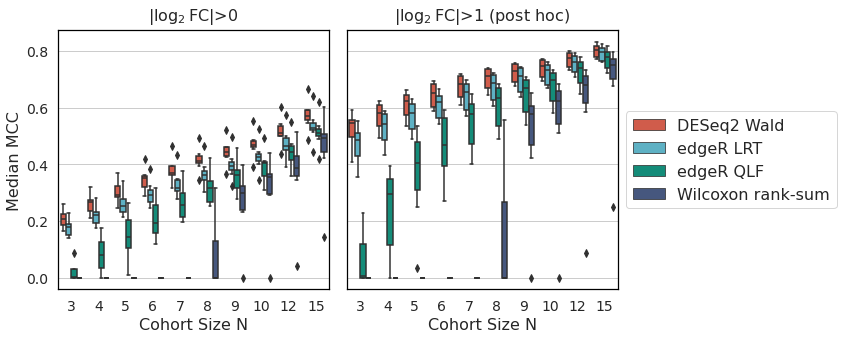

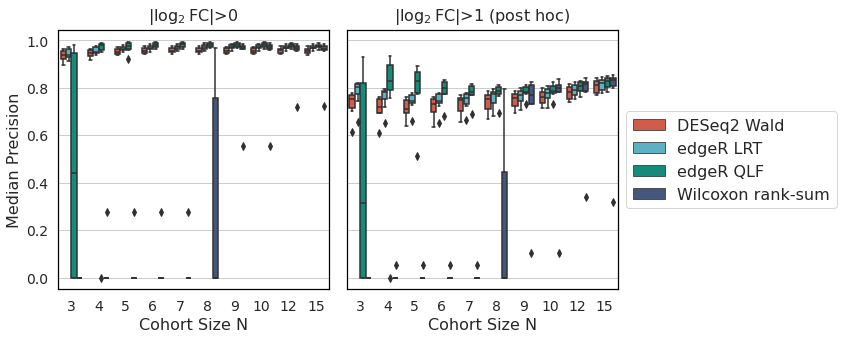

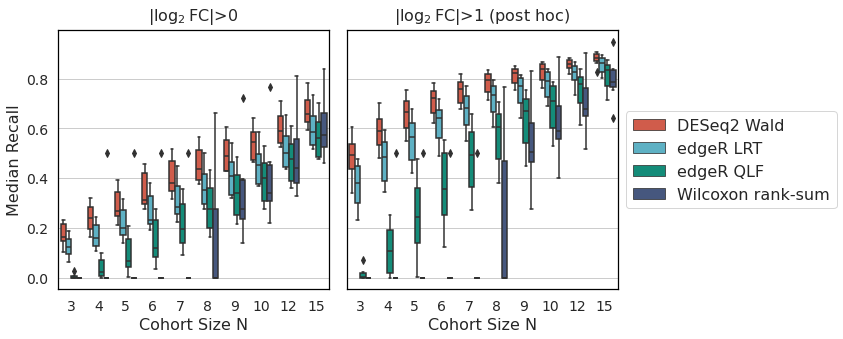

In [62]:
sns.set_style("whitegrid", {'axes.linewidth': 2, 'axes.edgecolor':'black'})

palette = npg

metrics = {"median_mcc0":"Median MCC", "median_prec0":"Median Precision", "median_rec":"Median Recall"}

for j, metric in enumerate(metrics):
    
    fig, ax = plt.subplots(1,2,figsize=(12,5), sharey=True)
    ax = ax.flatten()

    a  = wilcox[wilcox["logFC"]==0]
    a = a[a["FDR"]==0.05]
    a = a[a["Out"]=="None"]
    
    ylim = (min(a[metric]),max(a[metric]))

    sns.boxplot(data=a, x="N", y=metric,hue="DEA", ax=ax[0], palette=palette)

    a  = wilcox[wilcox["logFC"]==1]
    a = a[a["FDR"]==0.05]
    a = a[a["Out"]=="None"]
    
    ylim = (min(ylim[0], min(a[metric])) - 0.035,
            1.1 * max(ylim[1], max(a[metric])))
    

    sns.boxplot(data=a, x="N", y=metric,hue="DEA", ax=ax[1], palette=palette)
    
    ax[0].set_title(r"$|\log_2\mathrm{FC}$|>0",size=16, pad=10)
    ax[1].set_title(r"$|\log_2\mathrm{FC}$|>1 (post hoc)",size=16, pad=10)
    
    for i, a in enumerate(ax):
        a.legend([],[], frameon=False)
        a.set(xlabel="Cohort Size N")
        #a.annotate(chr(ord('A')+i), xy=(0, -0.12), xycoords="axes fraction", weight="bold", va='center',ha='center', fontsize=20)
        if i == 0: a.set(ylabel=metrics[metric])
        else: a.set(ylabel=None)
        #a.set_ylim(ylim[0],ylim[1])
        
    handles, labels = ax[0].get_legend_handles_labels()
    ax[1].legend(handles, labels, loc='lower right',framealpha=1)
    sns.move_legend(ax[1], "center left", bbox_to_anchor=(1, 0.5))
    
    fig.tight_layout()
    figpath = f"../figures/sfig{22+j}_wilcox_{metric}.pdf"
    fig.savefig(figpath)

# Non-TCGA Data

- https://www.ncbi.nlm.nih.gov/geo/query/acc.cgi?acc=GSE129622
- - mus musculus, n=359, many DEGS, small FC

## Tuberculosis

https://www.ncbi.nlm.nih.gov/pmc/articles/PMC6008327/

https://www.ncbi.nlm.nih.gov/pmc/articles/PMC3492754/

https://www.ncbi.nlm.nih.gov/geo/query/acc.cgi?acc=GSE107995

- Compare TB vs LTBI/control
- GSE107991 Berry London: test set (n=54) 
- GSE107992 Berry South Africa: valiadtion set (n=51)
- Leicester: active TB (n=53), recent close contacts (n=108)
-- Close contacts: IGRA negative (n=50), IGRA positive (n=49), TB active (n=9)
- LTBI outliers: cluster with active TB

In [4]:
def get_GSE_meta_data(foldername, series_matrix_file, skiprows=0):
    if series_matrix_file.endswith(".tsv"):
        meta = pd.read_csv(f"../data/{foldername}/{series_matrix_file}", sep="\t", on_bad_lines='warn', header=None, skiprows=skiprows)
    elif series_matrix_file.endswith(".txt.gz"):
        meta = pd.read_csv(f"../data/{foldername}/{series_matrix_file}", sep="\t", on_bad_lines='warn', header=None, skiprows=skiprows, compression='gzip')
    else:
        raise Exception("Invalid file")

    meta = meta.set_index(0).T
    meta.columns = [c[1:] for c in meta.columns]
    meta = meta.set_index("Sample_title")

    covariants = meta["Sample_characteristics_ch1"]
    covariants.columns = covariants.iloc[-1,:].str.split(":").str[0].str.strip()
    covariants.columns[0]
    covariants.columns.name = ""
    covariants.index.name = "Sample"
    covariants = covariants.map(lambda x: x.split(":")[1].strip() if isinstance(x, str) else x)
    covariants["Series"] = covariants.index.str.split("_Sample").str[0]
    covariants.reset_index(inplace=True)
    return covariants

def get_GSE_count_matrix(foldername, counts_matrix_file, metadata, series_name, control_name, case_name):
    if counts_matrix_file.endswith(".csv"):
        counts = pd.read_csv(f"../data/{foldername}/{counts_matrix_file}", index_col=0)
    elif counts_matrix_file.endswith(".txt.gz"):
        counts = pd.read_csv(f"../data/{foldername}/{counts_matrix_file}", sep='\t', compression='gzip')
    else:
        raise Exception("Invalid file")
        
    counts = counts[counts["Gene_biotype"] == "protein_coding"]
    counts = counts.set_index(['Gene_name', 'Gene_biotype'], append=True)

    cov = metadata[metadata['Series'] == series_name]

    assert (counts.columns.values == cov["Sample"].values).all()

    multi_columns = pd.MultiIndex.from_frame(cov)
    counts.columns = multi_columns
    
    control = counts.iloc[:,counts.columns.get_level_values("group")==control_name]
    case = counts.iloc[:,counts.columns.get_level_values("group")==case_name]
    N = min(len(control.columns), len(case.columns))
    final =pd.concat([control.iloc[:,:N], case.iloc[:,:N]], axis=1)

    final.index = final.index.get_level_values("Genes")
    final.columns = final.columns.get_level_values("Sample").astype(str) + "_" + final.columns.get_level_values("group").astype(str)

    return final

In [5]:
covariants = get_GSE_meta_data("GSETB","GSE107995_series_matrix.tsv",skiprows=27)
covariants.head()

,Sample,tissue,group,outlier,patient_id,tb_disease_type,smear_result,ethnicity,birth_place,uk_arrival_year,gender,age_at_baseline_visit,visit_date,timepoint_months,Series
0,Berry_London_Sample1,Whole blood,Active_TB,No,10061,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Berry_London
1,Berry_London_Sample2,Whole blood,Active_TB,Yes,30006,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Berry_London
2,Berry_London_Sample3,Whole blood,LTBI,Yes,10080,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Berry_London
3,Berry_London_Sample4,Whole blood,LTBI,No,10124,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Berry_London
4,Berry_London_Sample5,Whole blood,Control,No,10111,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Berry_London


In [6]:
covariants["Series"].value_counts()

Series
Leicester_with_progressor_longitudinal       175
Leicester_non_progressor_longitudnal_only    138
Berry_London                                  54
Berry_SouthAfrica                             47
Name: count, dtype: int64

In [7]:
covariants.groupby("Series")["group"].value_counts()

Series                                     group          
Berry_London                               Active_TB          21
                                           LTBI               21
                                           Control            12
Berry_SouthAfrica                          LTBI               31
                                           Active_TB          16
Leicester_non_progressor_longitudnal_only  Control            69
                                           LTBI               69
Leicester_with_progressor_longitudinal     Active_TB          53
                                           Control            50
                                           LTBI               49
                                           LTBI_Progressor    23
Name: count, dtype: int64

In [8]:
counts = get_GSE_count_matrix("GSETB", "GSE107994_Raw_counts_Leicester_with_progressor_longitudinal.csv",
                              covariants, "Leicester_with_progressor_longitudinal", "Control", "Active_TB")

In [ ]:
counts.columns.get_level_values('group').value_counts()
counts.columns.get_level_values('smear_result').value_counts()
#counts.columns.get_level_values('outlier').value_counts()

In [12]:
#counts.to_csv("../data/GSETB/LWPL/LWPL.csv")
print(counts.shape)
counts.head()

(19961, 100)


,Leicester_with_progressor_longitudinal_Sample10_Control,Leicester_with_progressor_longitudinal_Sample12_Control,Leicester_with_progressor_longitudinal_Sample15_Control,Leicester_with_progressor_longitudinal_Sample17_Control,Leicester_with_progressor_longitudinal_Sample20_Control,Leicester_with_progressor_longitudinal_Sample21_Control,Leicester_with_progressor_longitudinal_Sample22_Control,Leicester_with_progressor_longitudinal_Sample30_Control,Leicester_with_progressor_longitudinal_Sample32_Control,Leicester_with_progressor_longitudinal_Sample36_Control,...,Leicester_with_progressor_longitudinal_Sample144_Active_TB,Leicester_with_progressor_longitudinal_Sample155_Active_TB,Leicester_with_progressor_longitudinal_Sample158_Active_TB,Leicester_with_progressor_longitudinal_Sample159_Active_TB,Leicester_with_progressor_longitudinal_Sample160_Active_TB,Leicester_with_progressor_longitudinal_Sample161_Active_TB,Leicester_with_progressor_longitudinal_Sample162_Active_TB,Leicester_with_progressor_longitudinal_Sample170_Active_TB,Leicester_with_progressor_longitudinal_Sample175_Active_TB,Leicester_with_progressor_longitudinal_Sample179_Active_TB
Genes,,,,,,,,,,,,,,,,,,,,,
ENSG00000000003,2,3,0,4,0,4,9,0,0,10,...,5,1,0,0,3,2,1,0,0,0
ENSG00000000005,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
ENSG00000000419,235,511,261,271,186,251,273,130,223,159,...,278,369,136,152,186,226,176,78,215,362
ENSG00000000457,252,546,297,357,332,349,375,177,274,265,...,267,359,232,256,260,178,232,161,358,399
ENSG00000000460,52,134,52,67,62,49,76,30,25,70,...,47,61,40,28,58,48,36,42,88,84


In [ ]:
deg = pd.read_csv("../data/GSETB/LWPL/LWPL.edgerlrt.lfc0.csv", index_col=0)
deg[deg["FDR"]<0.05]

### Results

In [4]:
combined_td3 = pd.read_csv("../data/multi/combined_td.p3.csv", index_col=0) # Unpaired formal lfc 1
combined_td3["DEA"] = combined_td3["DEA"].str.replace("edgerqlf","edgeR QLF")


In [5]:
d = combined_td3[combined_td3["Data"]=="LWPL"]
d = d[(d["FDR"]==0.05)&(d["logFC"]==1)]

In [6]:
truth = pd.read_csv("../data/GSETB/LWPL/truth.fdr0.05.post_lfc1.lfc1.csv", index_col=0)

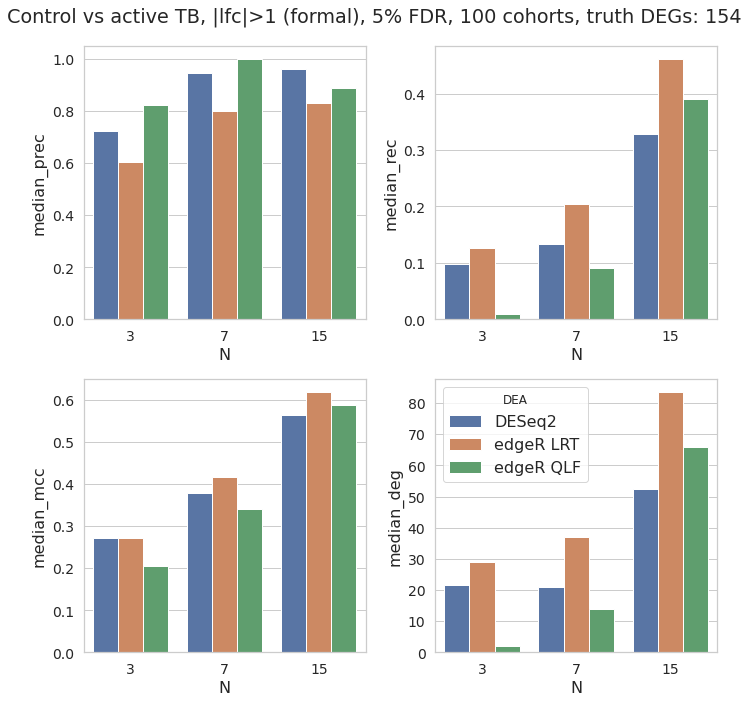

In [7]:
sns.set_style("whitegrid")

fig, ax = plt.subplots(2,2,figsize=(10,10))
ax=ax.flatten()
for i, met in enumerate(["median_prec","median_rec","median_mcc","median_deg"]):
    sns.barplot(data=d, x="N",y=met, hue="DEA", ax=ax[i])
    if i < 3: ax[i].legend().remove()

fig.suptitle(f"Control vs active TB, |lfc|>1 (formal), 5% FDR, 100 cohorts, truth DEGs: {len(truth)}")
fig.tight_layout()
figpath = f"../figures/LWPL_metrics.png"
fig.savefig(figpath)

## Bipolar

- https://www.ncbi.nlm.nih.gov/geo/query/acc.cgi?acc=GSE124326
- https://www.cambridge.org/core/journals/psychological-medicine/article/whole-blood-transcriptome-analysis-in-bipolar-disorder-reveals-strong-lithium-effect/F465E250F2403013A6590F150E4A7000
- N=240 controls (152 lithium use 88 non-user) and N=240 case
- 5% FDR => 976 DEGs related to lithium use, ony 6 BD DEGs

"The final covariate model for DEGs between subjects being treated with lithium (i.e. lithium users) and non-lithium users included the following variables: BD diagnosis, age, sex, tobacco use, ascertainment group, RIN, sequencing plate, and sequencing metric PCs 1 through 3."

In [ ]:
meta = get_GSE_meta_data("GSEBP","GSE124326_series_matrix.txt.gz",skiprows=37)
meta.head()

In [ ]:
#meta.groupby("Series")["group"].value_counts()
meta.columns

In [ ]:
counts = pd.read_csv(f"../data/GSEBP/GSE124326_count_matrix.txt.gz", sep='\t', compression='gzip')
counts = counts.set_index(['gene'], append=False)

counts.columns = counts.columns.str.split(".counts").str[0]
assert (counts.columns.values == meta["Sample"].values).all()

In [ ]:
multi_columns = pd.MultiIndex.from_frame(meta)
counts.columns = multi_columns

# Subset to case samples, yielding BP patients with and without lithium use
counts = counts.loc[:, counts.columns.get_level_values('bipolar disorder diagnosis') != 'Control']

control = counts.iloc[:,counts.columns.get_level_values("lithium use (non-user=0, user = 1)")=="0"]
case = counts.iloc[:,counts.columns.get_level_values("lithium use (non-user=0, user = 1)")=="1"]
N = min(len(control.columns), len(case.columns))
final =pd.concat([control.iloc[:,:N], case.iloc[:,:N]], axis=1)
final.columns = final.columns.get_level_values("Sample").astype(str) + "_" + final.columns.get_level_values("lithium use (non-user=0, user = 1)").astype(str)

In [ ]:
final.to_csv("../data/GSEBP/BPLT/BPLT.csv")

# 176 samples, 88 per lithium-use condition
final.shape

### Results

~1000 DEGs in ground truth, but sample sizes up to N=15 insufficient to detect any DEGs

In [ ]:
tab = pd.read_csv("/storage/homefs/pd21v747/RNASeqReplicability/data/GSEBP/BPLT/BPLT.deseq2.lfc0.csv", index_col=0)
tab[tab["FDR"]<0.05]

## Chronic hypersensitivity pneumonitis

- https://www.ncbi.nlm.nih.gov/geo/query/acc.cgi?acc=GSE150910
- lung samples from CHP (N=82), IPF (N=103), and unaffected controls (N=103) was conducted. Differential gene expression was determined adjusting for sex, race, age and smoking history, and using false discovery rate (FDR) to control for multiple comparisons. (IPF = idiopathic pulmonary fibrosis)
- When compared with controls, we identified 413 upregulated and 317 downregulated genes in CHP and 861 upregulated and 322 downregulated genes in IPF. (FDR <  0.05, abs(lfc) > 1, DESeq2)

In [6]:
meta = get_GSE_meta_data("GSEPN","GSE150910_series_matrix.txt.gz",skiprows=29)
meta.head()

,Sample,tissue,Sex,age,diagnosis,ever_smoked,"race (hispanic;1, black;3,asian;4, white;5, other;6)",rs35705950_genotype,sample type,psl,is,antigen_identified,batch,lane,plate,institution,Series
0,chp_1,lung tissue,female,69,chp,no,5,GG,biopsy,NO,NO,NO,2020-06-05,H05,1,LTRC,chp_1
1,chp_2,lung tissue,female,56,chp,yes,5,GT,biopsy,YES,NO,YES,2020-06-05,H03,1,LTRC,chp_2
2,chp_3,lung tissue,male,69,chp,no,5,GT,biopsy,NO,NO,YES,2020-06-05,F04,1,LTRC,chp_3
3,chp_4,lung tissue,female,67,chp,yes,5,GG,biopsy,NO,NO,YES,2020-06-05,C07,1,LTRC,chp_4
4,chp_5,lung tissue,female,66,chp,yes,5,GT,biopsy,NO,NO,YES,2020-06-05,B06,1,LTRC,chp_5


In [94]:
counts = pd.read_csv(f"../data/GSEPN/GSE150910_gene-level_count_file.csv", sep=',')
counts = counts.set_index(['symbol'], append=False)
counts.columns = counts.columns.str.split(".counts").str[0]
counts = counts[sorted(counts.columns)]
meta = meta.sort_values(by="Sample")
assert (counts.columns.values == meta["Sample"].values).all()

In [95]:
counts = pd.read_csv("../data/GSEPN/GIPF/GIPF.csv", index_col=0)
n_control = counts.columns.str.startswith("control").sum()
n_treat = counts.columns.str.startswith("ipf").sum()
m = min(n_control, n_treat)
print(n_control, n_treat)
counts = pd.concat([counts.iloc[:,:m], counts.iloc[:,n_control:n_control+m]], axis=1)
n_control = counts.columns.str.startswith("control").sum()
n_treat = counts.columns.str.startswith("ipf").sum()
print(n_control, n_treat)

103 102
102 102


In [96]:
meta = get_GSE_meta_data("GSEPN","GSE150910_series_matrix.txt.gz",skiprows=29)
meta.head()

cols = ["Sample","Sex","age","ever_smoked","race (hispanic;1, black;3,asian;4, white;5, other;6)"]
meta = meta[cols]

# Remove CHP samples
meta = meta[~meta["Sample"].str.startswith("chp")]

# Clean df
meta.rename({"race (hispanic;1, black;3,asian;4, white;5, other;6)":"race"}, axis=1, inplace=True)
meta.replace("NA", "unknown", inplace=True)
meta["age"].replace("unknown", np.nan, inplace=True)
meta["age"] = meta["age"].astype(float)
print("nan age counts:", meta["age"].isna().sum())
meta = meta.dropna()
meta.set_index("Sample", inplace=True)
meta["Condition"] = meta.index.str.split("_").str[0]
meta = meta.sort_index()
meta

nan age counts: 1


,Sex,age,ever_smoked,race,Condition
Sample,,,,,
control_1089,female,50.0,yes,1,control
control_1092,female,53.0,no,1,control
control_1096,female,64.0,unknown,3,control
control_1097,male,53.0,no,1,control
control_1102,female,59.0,yes,4,control
...,...,...,...,...,...
ipf_990,male,48.0,no,5,ipf
ipf_992,male,45.0,yes,5,ipf
ipf_994,female,68.0,no,5,ipf


In [98]:
meta = meta.loc[counts.columns]
counts = counts[meta.index]
meta.to_csv("../data/GSEPN/GIPF/GIPF.meta.csv")
counts.to_csv("../data/GSEPN/GIPF/GIPF.csv")

In [10]:
tab = pd.read_csv("../data/test/test.csv", index_col=0)
tab_unpaired = pd.read_csv("../data/test/test_unpaired.csv", index_col=0)
tab_treat = pd.read_csv("../data/test/test_treat.csv", index_col=0)
sig = tab[(tab["FDR"]<0.05)&(tab["logFC"].abs()>1)]
sig_unpaired = tab_unpaired[(tab_unpaired["FDR"]<0.05)&(tab_unpaired["logFC"].abs()>1)]
sig_treat = tab_treat[(tab_treat["FDR"]<0.05)&(tab_treat["logFC"].abs()>1)]

len(sig), len(sig_unpaired), len(sig_treat)

(2055, 2090, 961)

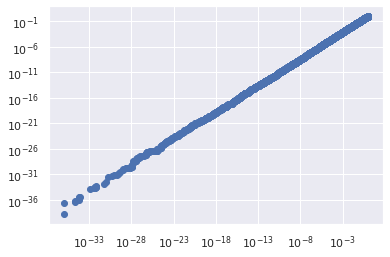

In [13]:
plt.scatter(tab["FDR"],tab_unpaired["FDR"])
plt.xscale("log")
plt.yscale("log")

In [54]:
final.to_csv("../data/GSEPN/GIPF/GIPF.csv")

In [ ]:
%%R

library(edgeR)

In [ ]:
import sys, importlib
importlib.reload(sys.modules["misc"])
importlib.reload(sys.modules["DEA"])

from DEA import run_dea

## Combined

In [176]:
combined_td = pd.read_csv("../data/multi/combined_td.p3.csv", index_col=0)
combined_td = combined_td[combined_td["Data"].isin(["GIPF","LWPL"])]

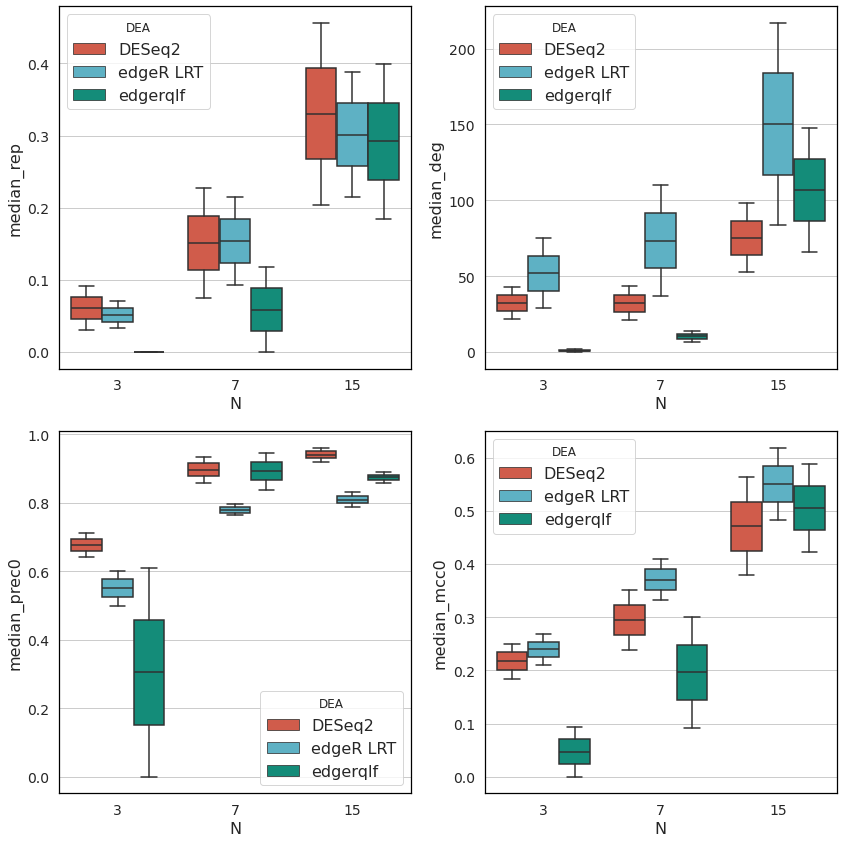

In [179]:
fig,ax=plt.subplots(2,2,figsize=(12,12))
ax=ax.flatten()
sns.boxplot(data=combined_td,x="N",y="median_rep",hue="DEA",ax=ax[0], palette=np.array(npg)[[0,1,2]], fliersize=5)
sns.boxplot(data=combined_td,x="N",y="median_deg",hue="DEA",ax=ax[1], palette=np.array(npg)[[0,1,2]], fliersize=5)
sns.boxplot(data=combined_td,x="N",y="median_prec0",hue="DEA",ax=ax[2], palette=np.array(npg)[[0,1,2]], fliersize=5)
sns.boxplot(data=combined_td,x="N",y="median_mcc0",hue="DEA",ax=ax[3], palette=np.array(npg)[[0,1,2]], fliersize=5)

fig.tight_layout()

# Ground truth stability vs N

In [25]:
site = "kidney"
dea = "edgerqlf"
out = "none"
paramset = "p2"
dataset = sites[site]
overwrite = False

dea_kwargs = {"filter_expr": False, "cols_to_keep": ["logFC","logCPM","FDR"], "lfc": 1 if paramset=="p2" else 0, 
              "design": "paired", "check_gof": False, "verbose": False}
    
f = f"../data/{site}/{dataset}/{dataset}"
tab = open_table(f)

In [26]:
from misc import paired_replicate_sampler
from DEA import run_dea

max_N = len(tab.columns)//2

for N in range(3, max_N-1):
    if N%2!=0: continue
    if N > 30 and N%8!=0: continue
    print(f"{N} of {max_N}")
    df = paired_replicate_sampler(tab, N)[0]
    outfile = f"../data/test/ground_truth_stability/{dataset}.N{N}.{paramset}.csv"
    run_dea(df, outfile, dea, overwrite=overwrite, **dea_kwargs)

4 of 72
[1] "Existing table not overwritten"
6 of 72
[1] "Existing table not overwritten"
8 of 72
[1] "Existing table not overwritten"
10 of 72
[1] "Existing table not overwritten"
12 of 72
[1] "Existing table not overwritten"
14 of 72
[1] "Existing table not overwritten"
16 of 72
[1] "Existing table not overwritten"
18 of 72
[1] "Existing table not overwritten"
20 of 72
[1] "Existing table not overwritten"
22 of 72
[1] "Existing table not overwritten"
24 of 72
[1] "Existing table not overwritten"
26 of 72
[1] "Existing table not overwritten"
28 of 72
[1] "Existing table not overwritten"
30 of 72
[1] "Existing table not overwritten"
32 of 72
[1] "Existing table not overwritten"
40 of 72
[1] "Existing table not overwritten"
48 of 72
[1] 96
[1] 96
56 of 72
[1] 112
[1] 112
64 of 72
[1] 128
[1] 128


In [30]:
fdr = 0.05
lfc = 1

f = f"../data/{site}/{dataset}/truth.fdr{fdr}.post_lfc{lfc}.lfc{lfc}.csv"
tab_truth = open_table(f)

In [54]:
Ns, jaccs = [], []

for N in range(3,72):
    
    if N not in [3,4,5,6,7,8,9,10,12,15]:
        f = f"../data/test/ground_truth_stability/{dataset}.N{N}.{paramset}.csv" 
        try:
            tab_N = open_table(f)
        except FileNotFoundError:
            continue
    
    
        deg = tab_N[(tab_N["FDR"]<fdr)&(tab_N["logFC"].abs()>lfc)]
        inter = len(deg.index.intersection(tab_truth.index))
        union = len(deg.index.union(tab_truth.index))
        jaccs.append(inter/union)
        
    else:
        f = f"../data/{site}/{dataset}/{dataset}_N{N}/all.FDR.{out}.{dea}.{paramset}"
        tab_N = open_table(f)
        tab_N
        truth_degs=pd.DataFrame(index=tab_N.index)
        truth_degs["IsTruthDEG"] = False
        truth_degs.loc[tab_truth.sort_index().index, "IsTruthDEG"] = True

        a=(tab_N<fdr)
        inter = (truth_degs["IsTruthDEG"].values & a.T).T
        union = (truth_degs["IsTruthDEG"].values | a.T).T
        jaccs.append(np.median(inter.sum() / union.sum()))

    Ns.append(N)

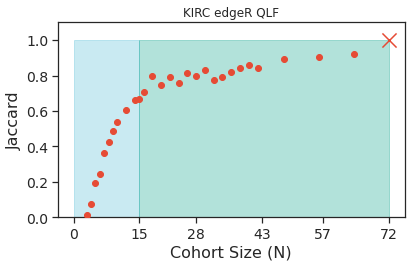

In [65]:
sns.set_style("ticks")

def limits(a, b, ax):
    if a>b : a, b = b, a
    ymin, ymax = ax.get_ylim()
    dy = ymax-ymin
    return ((y-ymin)/dy for y in (a, b))
    
fig, ax = plt.subplots(1,1)

ax.scatter(Ns,jaccs, zorder=99, color=npg[0])
ax.scatter(max_N,1, zorder=99,marker="x",s=200,color=npg[0])

# ax.axhline(1,ls="--",color="grey")
# ax.axvline(max_N,ls="--",color="grey")
# ax.axvline(15,ls="--",color="grey")
ax.set_ylabel("Jaccard")
ax.set_xlabel("Cohort Size (N)")
ax.set_title(f"{dataset} {prdea[dea]}")
ax.set(ylim=(0,1.1), xlim=(-0.05*max_N, 1.05*max_N))

ax.axvspan(0, 15, *limits(0,1, ax), color=npg[1], alpha=0.3)
ax.axvspan(15, 72, *limits(0,1, ax), color=npg[2], alpha=0.3)



xticks = np.linspace(0, max_N, num=6)
xticks = np.array([int(x) for x in xticks])
xticklabels = [str(x) for x in xticks]

closest_idx = np.abs(xticks - 15).argmin()
if xticks[closest_idx] != 15:
    xticks[closest_idx] = 15
    xticklabels[closest_idx] = "15"

xticks, xticklabels = zip(*sorted(zip(xticks, xticklabels)))
ax.set(xticks=xticks, xticklabels=xticklabels)

fig.tight_layout()
#figpath = f"../figures/{site}.jacc_vs_n.png"
#fig.savefig(figpath)

# Subampling with replacement

In [4]:
import json
from math import comb

def get_list_of_cohort_pairs_without_repeating_samples(site, dataset, N, cohorts, return_dfp=False):
    dfp = pd.DataFrame(index=range(1,cohorts+1), columns=range(1,N+1))
    for cohort in range(1, cohorts+1):
        f_c = f"../data/{site}/{dataset}/{dataset}_N{N}/{dataset}_N{N}_{cohort:04}/config.json"
        with open(f_c, "r") as f:
            configdict = json.load(f)

            samples = configdict["samples_i"][:N]
            samples = [int(s[1:]) for s in samples]
            dfp.loc[cohort] = samples

    cohort_pairs_without_repeating_samples = []

    for i, base_cohort in enumerate(dfp.index):
        for cohort in dfp.iloc[i:].index:
            if cohort == base_cohort: continue

            if (dfp.loc[base_cohort] == dfp.loc[cohort]).sum() == 0:
                cohort_pairs_without_repeating_samples.append((base_cohort,cohort))
                
    if return_dfp:
        return cohort_pairs_without_repeating_samples, dfp 
    return cohort_pairs_without_repeating_samples

from numba import njit
from process import get_replicability_numba

#@njit()
def get_replicability_numba_on_specified_pairs(boolarr, pairs):
    """
    boolarr: boolean np.array of shape (nrow = n_genes, ncols = n_cohorts), true if gene is DEG in cohort
    pairs: list of (int,int) specifying pair of cohorts
    returns list of jaccard indices for all pairs
    """
    rep = []
    col_sum = np.sum(boolarr, axis=0)
    for pair in pairs:
        i, j = pair[0]-1, pair[1]-1
        intersect = np.sum(boolarr[:, i] & boolarr[:, j])
        r = intersect / max(0.1, col_sum[i] + col_sum[j] - intersect)
        rep.append(r)
    return rep

In [7]:
cohorts = 100
all_N = [3,4,5,6,7,8,9,10,12,15]
out = "none"
dea = "edgerlrt"
param_set = "p1"
fdr = 0.05
logFC = 1

fracs = {sites[site]: {N: {"Frac":None,"median_rep_all":None,"median_rep_unique":None} for N in all_N} for site in sites}

for site in sites:
    print(site)
    for N in all_N:
        dataset = sites[site]
        pairs = get_list_of_cohort_pairs_without_repeating_samples(site, dataset, N, cohorts)
        fracs[dataset][N]["Frac"] = len(pairs) / comb(cohorts, 2)
        
        outpath_N = f"../data/{site}/{dataset}/{dataset}_N{N}"
        df_lfc = open_table(f"{outpath_N}/all.logFC.{out}.{dea}.{param_set}.feather")                    
        df_fdr = open_table(f"{outpath_N}/all.FDR.{out}.{dea}.{param_set}.feather")
        boolarr_deg = np.where((df_lfc.abs() > logFC) & (df_fdr < fdr), True, False)
        
        r = get_replicability_numba_on_specified_pairs(boolarr_deg, pairs)
        fracs[dataset][N]["median_rep_unique"] = np.median(r)
        
        r2 = get_replicability_numba(boolarr_deg)
        fracs[dataset][N]["median_rep_all"] = np.median(r2)

thyroid
lung
kidney
colorectal
breast
liver
prostate


../figures/sfig24_subsampling_with_replacemen.pdf


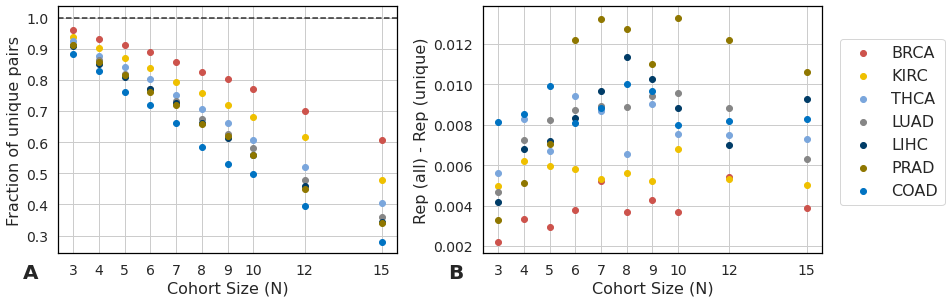

In [22]:
sns.set_style("whitegrid", {'axes.linewidth': 2, 'axes.edgecolor':'black'})

fig, ax = plt.subplots(1,2,figsize=(13.5,4.5))
palette = np.array(jco)

dataorder = [data for data in fracs]
dataorder = list(reversed(sorted(dataorder, key= lambda data: fracs[data][15]["Frac"])))

color_order = np.array(["COAD","KIRC","LUAD","BRCA","THCA","LIHC","PRAD"])
palette = {data:color for data, color in zip(color_order,jco)}

for dataset in dataorder:
    ax[0].scatter(all_N, [fracs[dataset][N]["Frac"] for N in all_N], label=dataset, color=palette[dataset])
    ax[1].scatter(all_N, [fracs[dataset][N]["median_rep_all"]-fracs[dataset][N]["median_rep_unique"] for N in all_N], 
                  label=dataset, marker="o", color=palette[dataset])

ax[0].set(xlabel="Cohort Size (N)", ylabel="Fraction of unique pairs")
ax[1].set(xlabel="Cohort Size (N)", ylabel="Rep (all) - Rep (unique)")

ax[0].axhline(1,ls="--",color="black",alpha=0.8)
ax[1].legend(bbox_to_anchor=(1.03, 0.9))

for i, a in enumerate(ax):
    a.set(xticks=all_N, xticklabels=all_N)
    a.annotate(chr(ord('A')+i), xy=(-0.08, -0.08), xycoords="axes fraction", weight="bold", va='center',ha='center', fontsize=20)

figpath = f"../figures/sfig24_subsampling_with_replacemen.pdf"
fig.tight_layout()
fig.savefig(figpath)
print(figpath)

# Prec vs #DEG

In [50]:
combined_td2 = pd.read_csv("../data/multi/combined_td.p2.csv", index_col=0) # Formal fold change thresholds
combined_td3 = pd.read_csv("../data/multi/combined_td.p3.csv", index_col=0)

combined_td3 = combined_td3[combined_td3["Data"].isin(["GIPF","LWPL"])]

dfs = [combined_td2, combined_td3]

for df in dfs:
    df["Out"].fillna("None", inplace=True)
    df["DEA"].replace(prdea, inplace=True)
    df["Out"].replace(prout, inplace=True)

In [51]:
combined_td2["Data"] = combined_td2["Data"].apply(lambda x: x.replace("_unpaired",""))

set(combined_td2["Data"])

df = pd.concat(dfs, axis=0)
methods = ['edgeR QLF', 'edgeR LRT', 'DESeq2 Wald']

In [52]:
df_sub = df[df["FDR"]==0.05]

pretty_metric = {"median_prec0": "Precision",
                "median_deg": "#DEGs",
                "median_rec": "Recall",
                "median_mcc0": "MCC"}

../figures/sfig29_prec_vs_deg.pdf


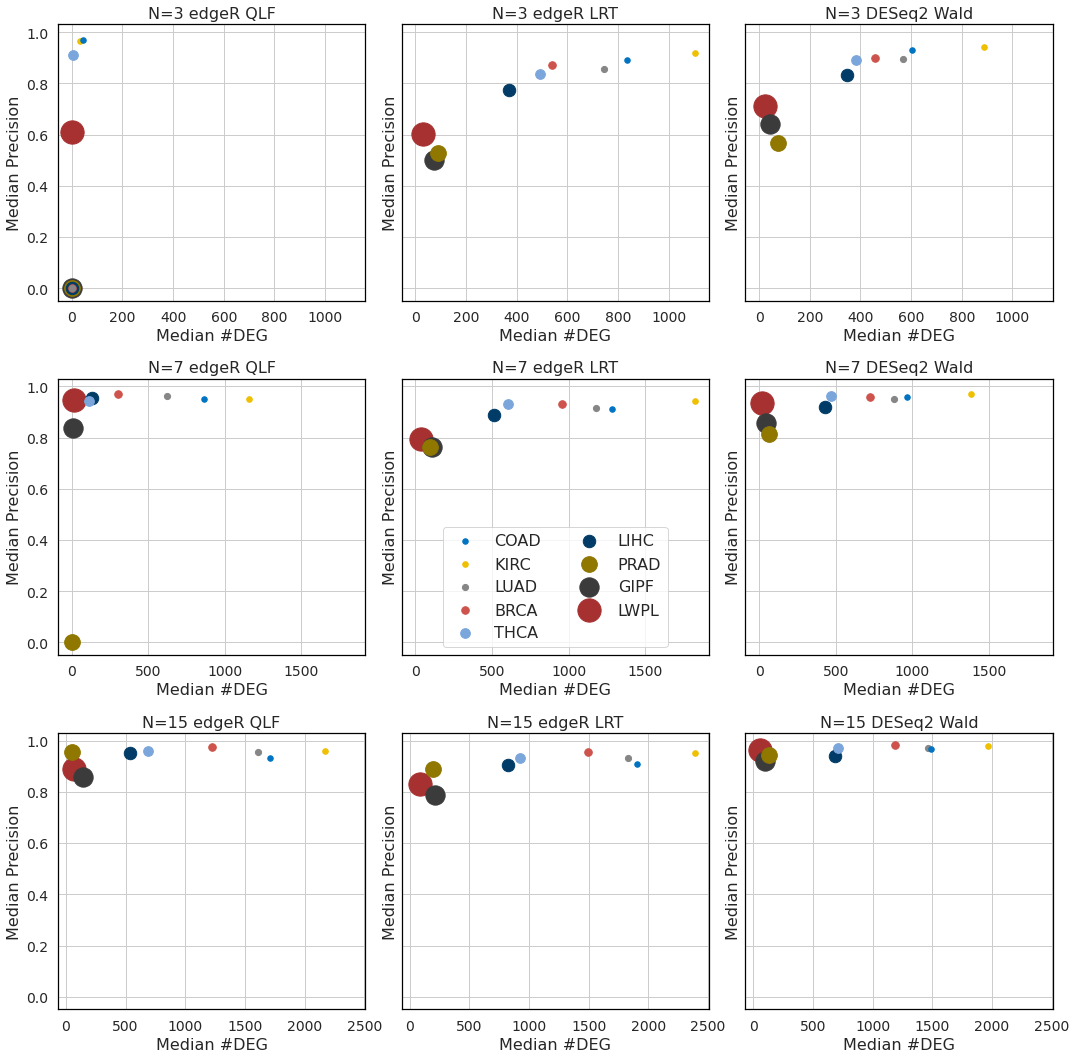

In [74]:
all_N = [3,7,15]
exclude_non_cancer = False

fig,ax=plt.subplots(3,len(all_N),figsize=(5*len(all_N),15), sharey=True, sharex="row")

color_order = np.array(["COAD","KIRC","LUAD","BRCA","THCA","LIHC","PRAD","GIPF","LWPL"])
palette = {data:color for data, color in zip(color_order,jco)}

for i, N in enumerate(all_N):
    dff = df_sub[df_sub["N"] == N]
    if exclude_non_cancer:
        dff = dff[~dff["Data"].isin(["GIPF","LWPL"])]
    for j, m in enumerate(methods):
        dfff = dff[dff["DEA"]==m]
        #sns.scatterplot(data=dfff, x="median_deg",y="median_prec0", hue="Data",ax=ax[i][j],palette=palette,s=100)
        
        for k, data in enumerate(color_order):
            dffff = dfff[dfff["Data"]==data]
            ax[i][j].scatter(dffff["median_deg"],dffff["median_prec0"],color=palette[data],s=k*k*k+30,zorder=99-k,label=data)
        ax[i][j].legend(loc="best")
        
        ax[i][j].set(xlabel="Median #DEG", ylabel="Median Precision")
        ax[i][j].set_title(f"N={N} {m}",size=16)

        if i!= 1 or j != 1: 
            ax[i][j].get_legend().set_visible(False)
        else:
            sns.move_legend(ax[i][j], "lower center", ncol=2)#, bbox_to_anchor=(1, 0.9))

figpath = f"../figures/sfig29_prec_vs_deg.pdf"
fig.tight_layout()
fig.savefig(figpath)
print(figpath)